
# spine recognition example using CNN

* filetype : .npy
* filecontent: [imageslist,labelslist,imageshape]
* imageslist: [img1,img2,...]
* labelslist: [0,1,1,0,...] 0:nospine 1:spine
* imageshape: img1.shape 

> Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [1]:
import os
import sys
from collections import Counter
from time import time

import matplotlib.pyplot as plt
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
sys.path.append("..")
from sklearn.utils import shuffle
from torch.optim import Adam,AdamW,Adagrad,RMSprop,SGD

from train.dataset.dataloader import ClassDataset
from train.networks.unetplusplus import CNN
from utils.file_base import file_list
from torch.utils.data import DataLoader
import torchfit
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:

def load(f):
    """load single npy"""
    dictl=np.load(f,allow_pickle=True)
    imgs,lables,size=dictl["img"],dictl["lab"],dictl["size"]
    print(f,size)
    # introspect the images arrays to find the shapes (for plotting)
    n_samples, h, w = len(imgs),imgs[0].shape[0],imgs[0].shape[1]
    X = np.array([np.array(img).ravel() for img in imgs])
    n_features = h*w
    y = np.array(lables,dtype=np.int8).ravel()
    return X,y,h,w
def loads(fs):
    """load multi npys"""
    XX,yy=None,None
    for f in fs:
        X2,y2,h,w=load(f)
        if XX is not None:
            XX=np.concatenate((XX,X2),axis=0)
            yy=np.concatenate((yy,y2),axis=0)
        else:
            XX=X2
            yy=y2
    label_num= list(np.unique(yy)).sort()
    return XX,yy,label_num,h,w
def mask_balance(XX,yy):
    rus = RandomUnderSampler(random_state=0)
    X_resampled, y_resampled = rus.fit_resample(XX, yy)
    print(sorted(Counter(y_resampled).items()))
    return X_resampled,y_resampled
def reshape_data(XX,h,w):
    X=[]
    for x in XX:
        # x=filters.sobel(x)
        x=x.reshape(h,w)
        x=x.astype(np.float32)
        X.append(x)
    print("img shape :",X[0].shape)
    return np.array(X)

def split_data(XX,yy):
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
    )
    print("Train num ",len(y_train),"Test num ",len(y_test))
    return X_train, X_test, y_train, y_test
def show_lable_distribution(Ys,lables=None):
    cols=len(Ys)
    fig, axs = plt.subplots(ncols=cols, figsize=(10, 5))
    fig.suptitle(" partion class for dataset")
    autopct = "%.2f"
    for ax,y in zip(axs,Ys):
        def absolute_value(val):
            a  = np.round(val/100*y.shape[0], 0)
            return str(np.round(val,2))+"% : "+str(a)
        yn,ns=np.unique(y,return_counts=True)
        if lables:
            ax.pie(ns,labels=lables,counterclock=True,autopct =absolute_value)
        else:
            ax.pie(ns,labels=yn,counterclock=True,autopct = absolute_value)

#show predict result
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
def title(y_pred, y_test,y_p, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s \nprob: %.2f" % (pred_name, true_name,y_p[i,1])


set dataset directory which include .npy files.

In [16]:
# set dataset directory
TRAINDIR=r"E:\code\myspine-20230422-torch\myspine-dataset\2D-morph-npy" # include [images,lables,boxsize]
checkponit_save_path= r"..\DATA\model\variables"
SAVE_model_path=r"..\DATA\model\cnn_model.pt"

load dataset from : 
	 E:\code\myspine-20230422-torch\myspine-dataset\2D-morph-npy\0319.npy.npz
	E:\code\myspine-20230422-torch\myspine-dataset\2D-morph-npy\0319_decon.npy.npz
	E:\code\myspine-20230422-torch\myspine-dataset\2D-morph-npy\20200724-1.npy.npz
	E:\code\myspine-20230422-torch\myspine-dataset\2D-morph-npy\20200808-2.npy.npz
	E:\code\myspine-20230422-torch\myspine-dataset\2D-morph-npy\202111-1.npy.npz
	E:\code\myspine-20230422-torch\myspine-dataset\2D-morph-npy\20211111-2.npy.npz
	E:\code\myspine-20230422-torch\myspine-dataset\2D-morph-npy\20211119-1.npy.npz
	E:\code\myspine-20230422-torch\myspine-dataset\2D-morph-npy\Stablized tboaltp20180128n3-116-16.npy.npz
E:\code\myspine-20230422-torch\myspine-dataset\2D-morph-npy\0319.npy.npz [16 16]
E:\code\myspine-20230422-torch\myspine-dataset\2D-morph-npy\0319_decon.npy.npz [16 16]
E:\code\myspine-20230422-torch\myspine-dataset\2D-morph-npy\20200724-1.npy.npz [16 16]
E:\code\myspine-20230422-torch\myspine-dataset\2D-morph-npy\2020080

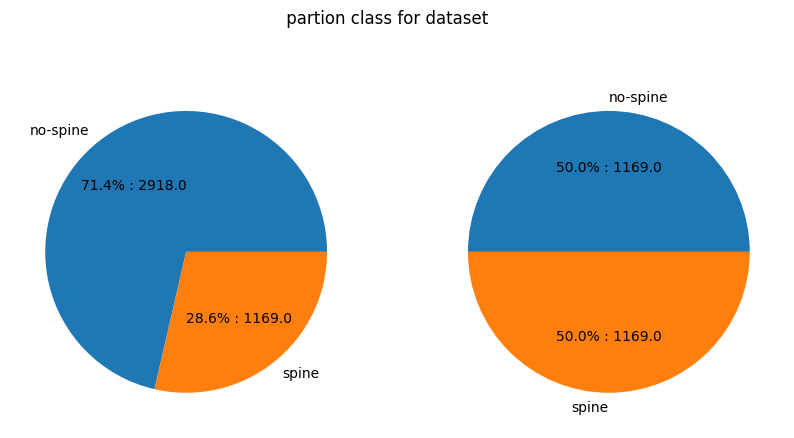

In [4]:
# load dataset
fs=file_list(TRAINDIR,"npz")
print("load dataset from : \n\t","\n\t".join(fs))
XX,yy,label_nums,h,w=loads(fs)
X,y=mask_balance(XX,yy)
X,y=shuffle(X,y)
X=reshape_data(X,h,w)
class_names=["no-spine","spine"]
show_lable_distribution([yy,y],class_names)
X_train, X_test, y_train, y_test=split_data(X,y)

In [8]:
#trian
dataset = ClassDataset(X_train, y_train,2)
vadataset = ClassDataset(X_test, y_test,2)
dataset_loader=DataLoader(dataset,8,True)
vadataset_loader=DataLoader(vadataset,8,True)
model=CNN(2,1,h).cuda()
learner = torchfit.Learner(model, dataset_loader, val_loader=vadataset_loader,
                           criterion=nn.CrossEntropyLoss(),
                           optimizer=Adam(model.parameters()),
                           device="cuda",
                          
                           )

learner.fit(0.0001, epochs=100)


Epoch 1 / 100
[========================================] 100%	  loss: 4.1124  accuracy: 0.6075  val_loss: 0.9115  val_accuracy: 0.5966

Epoch 2 / 100
[========================================] 100%	  loss: 0.6886  accuracy: 0.6486  val_loss: 0.6980  val_accuracy: 0.6188

Epoch 3 / 100
[========================================] 100%	  loss: 0.6012  accuracy: 0.6669  val_loss: 0.7344  val_accuracy: 0.6222

Epoch 4 / 100
[========================================] 100%	  loss: 0.5858  accuracy: 0.7017  val_loss: 0.6962  val_accuracy: 0.6325

Epoch 5 / 100
[========================================] 100%	  loss: 0.5584  accuracy: 0.7039  val_loss: 0.6278  val_accuracy: 0.6632

Epoch 6 / 100
[========================================] 100%	  loss: 0.5327  accuracy: 0.7102  val_loss: 0.7434  val_accuracy: 0.6547

Epoch 7 / 100
[========================================] 100%	  loss: 0.5089  accuracy: 0.7193  val_loss: 0.6926  val_accuracy: 0.7060

Epoch 8 / 100
[=================================

In [17]:
inn=torch.zeros(1,1,w,h).to("cuda")
model=torch.jit.trace(model,inn)
torch.jit.save(model, SAVE_model_path)

In [10]:
model=torch.jit.load(SAVE_model_path)

In [11]:
inX=X_test[:,None,...]
model.to("cpu")
y_p=model(torch.tensor(inX).to("cpu"))
y_pred=torch.argmax(y_p,dim=1).cpu().data.numpy()
# print(X.shape)

In [12]:
y_test.shape

(585,)

              precision    recall  f1-score   support

    no-spine       0.86      0.83      0.85       301
       spine       0.82      0.86      0.84       284

    accuracy                           0.84       585
   macro avg       0.84      0.84      0.84       585
weighted avg       0.85      0.84      0.84       585



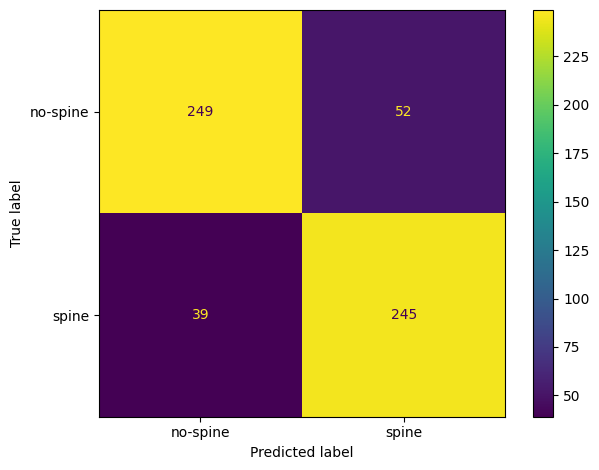

In [13]:

print(classification_report(y_test, y_pred, target_names=class_names))
# plt.figure(figsize=(18,18),dpi=32)
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=class_names, xticks_rotation="horizontal"
)
plt.tight_layout()
plt.show()
# lmodel.summary()


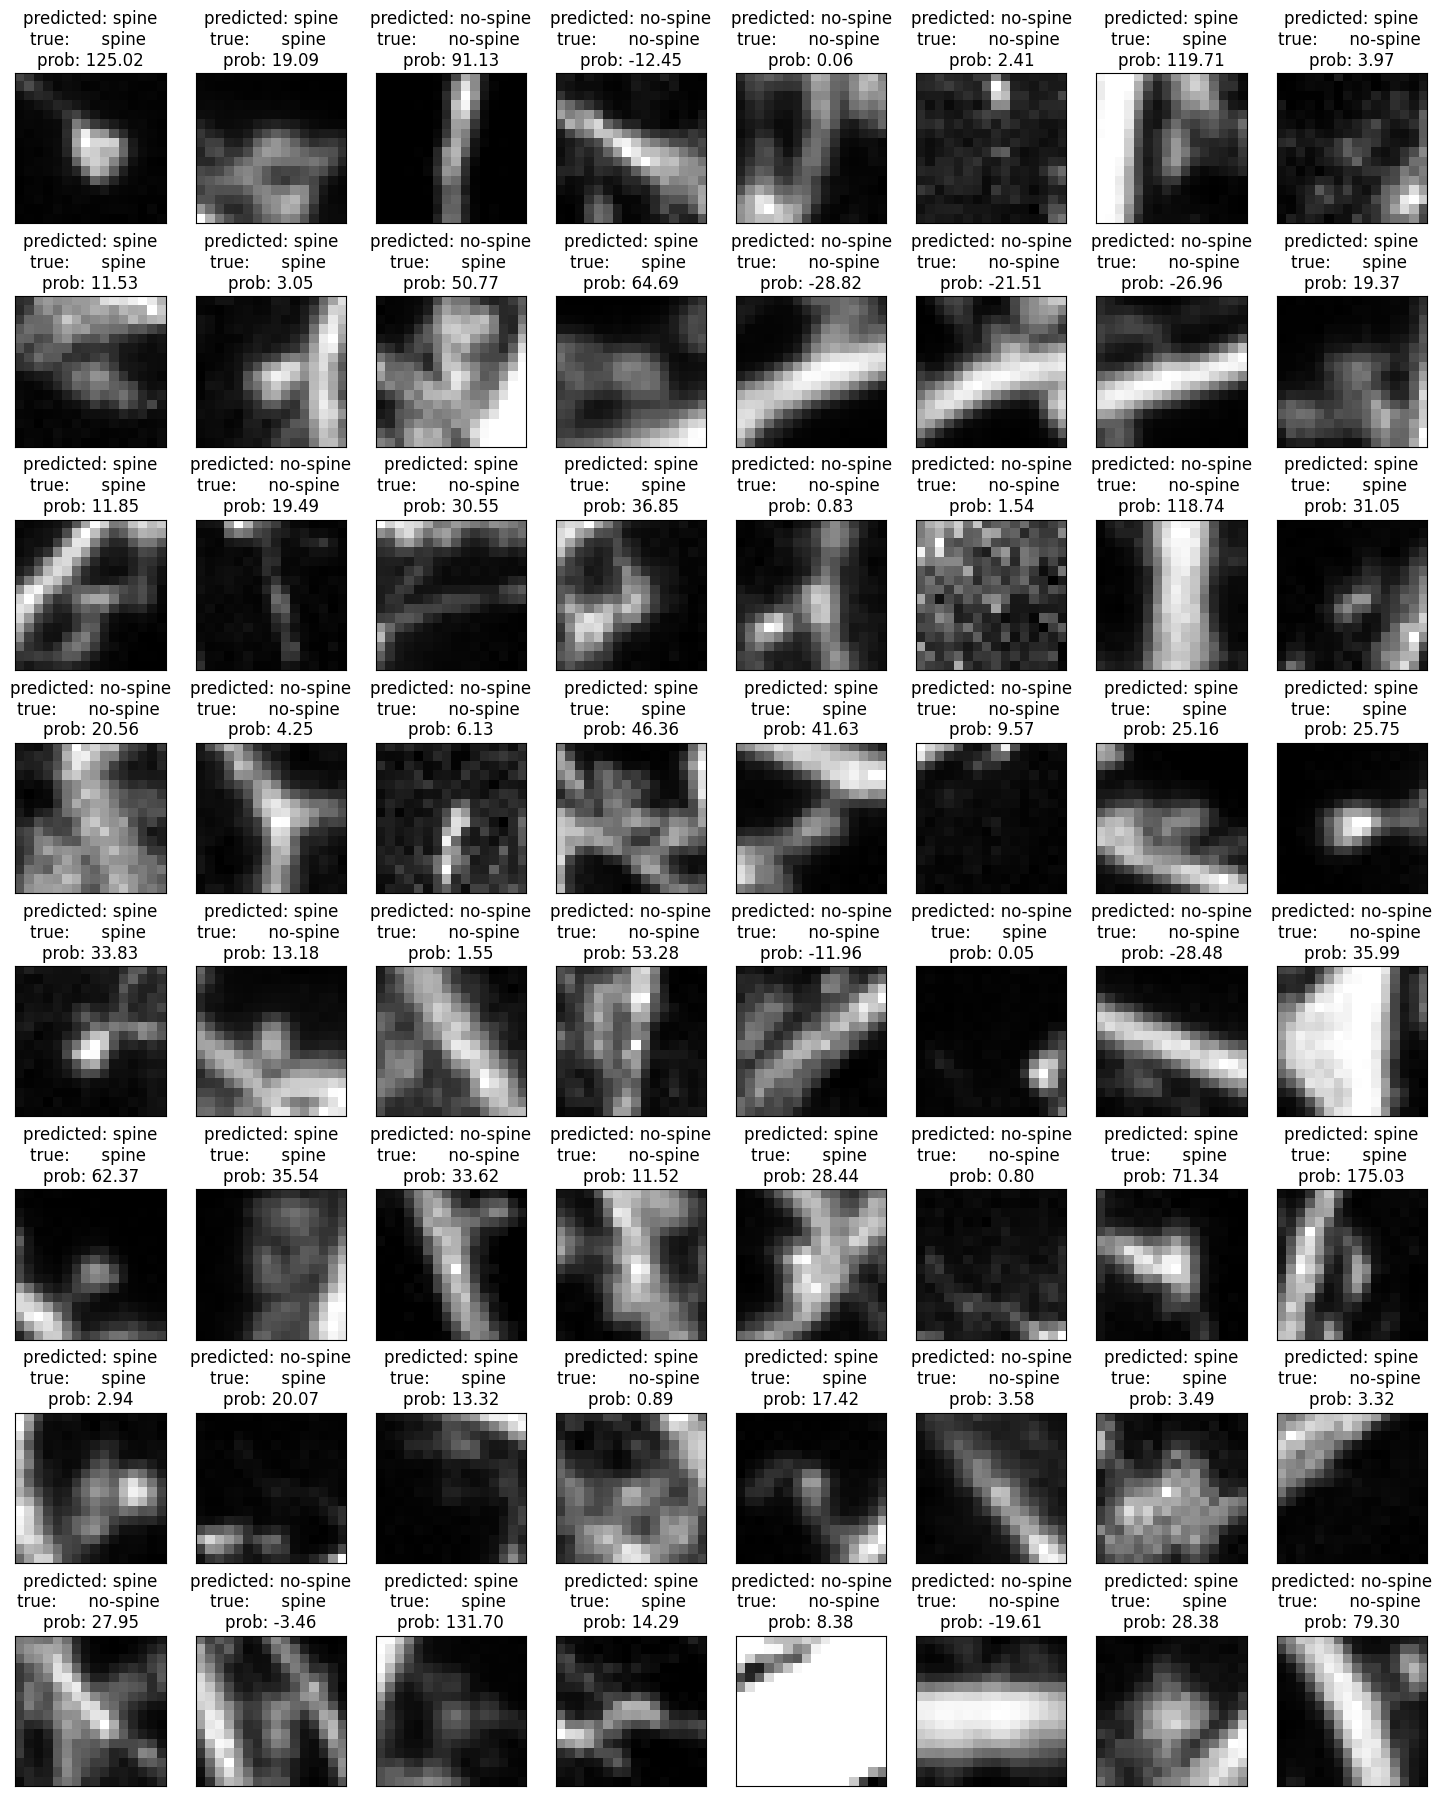

In [14]:
prediction_titles = [
    title(y_pred, y_test,y_p, class_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, 16, 16,8,8)